1. Выбрать набор данных.Распределение наборов данных по группам должно быть
равномерным. Название набора даных скопировать в таблицу с срапределениями по
командам, поставить + напротив соответствующей строки таблицы «Наборы данных»
2. Изучить набор данных, исследовать на пропуске, выбросы, балансировку по классам и тд
3. Для решения задачи выбрать 3 модели. Минимум одна модель – классическое машинное
обучение. Минимум одна модель – глубокий/нейросетевой подход.
4. Выбрать функцию потерь.
5. Выбрать критерии качества решения задачи.
6. Произвести тренировку моделей. Выбрать наилучший.
7. Подготовить презентацию с постановкой задачи, описание наборов данных, моделей,
результатами исследований.

Задача: обучить 3 модели на предсказание угла отклонения текста

In [1]:
import os
import shutil
import json
import matplotlib.pyplot as plt
import random
import PIL.Image as Image
import numpy as np
import pandas as pd
import time
import shutil
import math
import pathlib
import sys

from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.restoration import denoise_tv_chambolle
import cv2
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchsummary as summary

import tensorflow as tf
import keras

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor


# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# from tensorflow.keras.datasets import mnist
# from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import Iterator
# from tensorflow.keras.utils.np_utils import to_categorical
# import tensorflow.keras.backend as K

plt.ion()
from IPython.display import clear_output

/Users/denisdavydov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
root = 'scan_doc_rotation 2'
image_paths = os.path.join(root, 'images')
label_paths = os.path.join(root, 'labels')

In [3]:
test_list_path = os.path.join(root, 'test_list.json')

with open(test_list_path) as f:
    test_list = json.load(f)     # names of test images (test images dont have labels)

In [4]:
train_list_path = os.path.join(root, 'train_list.json')

with open(train_list_path) as f:
    train_list = json.load(f)   # names of train images

label_list = [x.split('.')[0] + '.txt' for x in train_list]   # names of label text files.

In [5]:
def get_random_img(r=[0, 499]):
    id = random.randint(r[0], r[1])
    sample_image_path = os.path.join(image_paths, train_list[id])
    sample_label_path = os.path.join(label_paths, label_list[id])
    return id, sample_image_path, sample_label_path

In [6]:
def display_image(path=None, img=None):
    if path is not None:
        img = Image.open(path)

    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')

ID of document is : 134
Rotation angle is : -0.03501648229435883


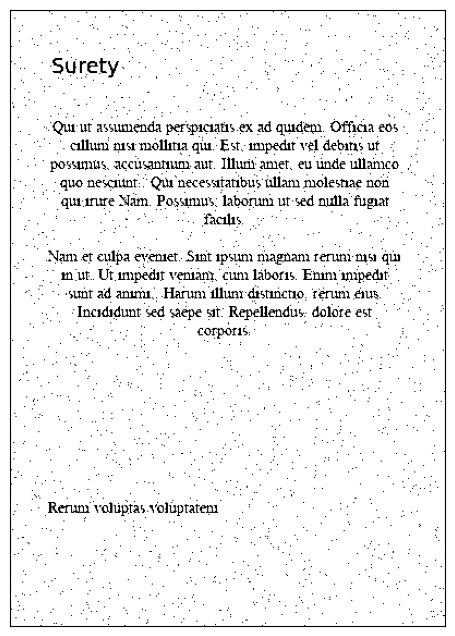

In [7]:
# generates random id and get it's image path and label path
id, sample_image_path, sample_label_path = get_random_img()

# displays image
display_image(path=sample_image_path)

# writes id and angle of sample in output
with open(sample_label_path) as f:
    angle = f.read()
print('ID of document is :', id)
print('Rotation angle is :', angle)

In [8]:
def display_image_grid(images, n=10, angles=None):
    fig = plt.figure(figsize=(20, 20))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(n, n),
                     axes_pad=0.25,
                     )

    i = 0
    for ax, im in zip(grid, images):
        ax.imshow(im, cmap='gray');
        ax.set_xticks([])
        ax.set_yticks([])
        if angles is not None:
            angle = angles[i] - 5
            ax.set_title(label=str(angle))
        i += 1

    plt.show()

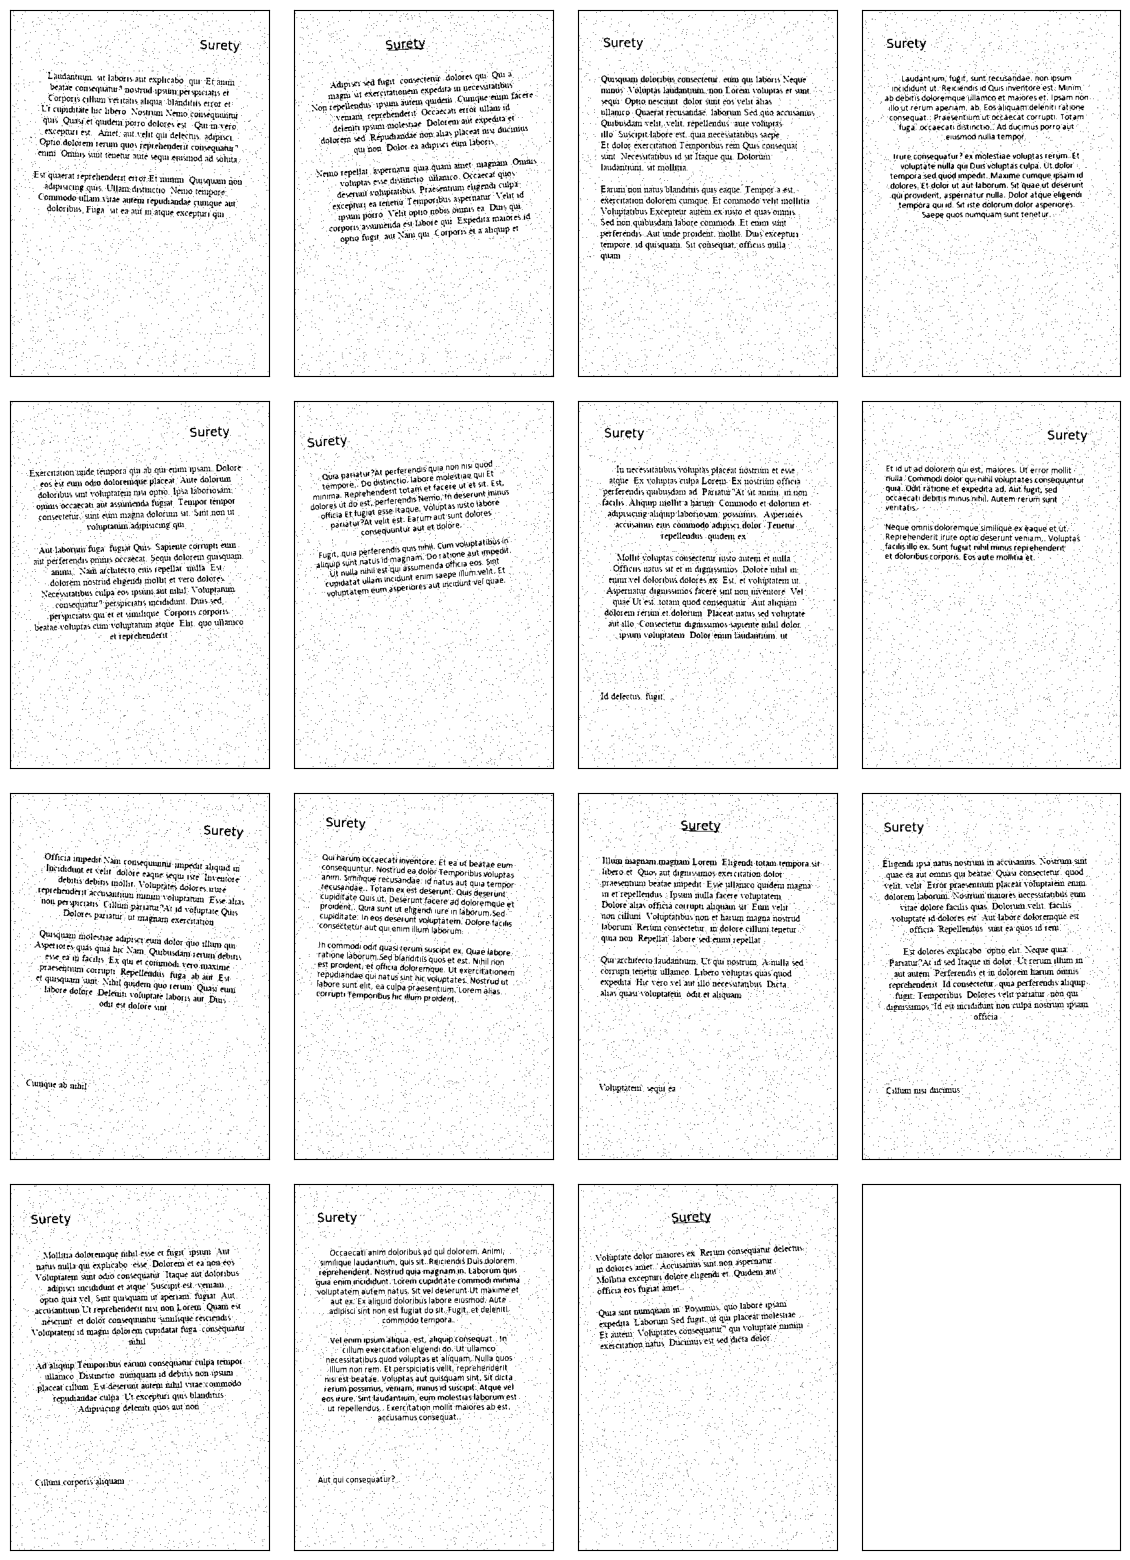

In [9]:
sampled_images = []
sampled_ids = []

for i in range(16):
    id, sample_image_path, sample_label_path = get_random_img()
    if id not in sampled_ids:
        img = Image.open(sample_image_path)
        sampled_ids.append(id)
        sampled_images.append(img)

display_image_grid(sampled_images, 4)

In [10]:
def denoise(img, to_PIL=True):
    img = denoise_tv_chambolle(img, weight=0.5)
    if to_PIL:
        Image.fromarray(img)
    return img

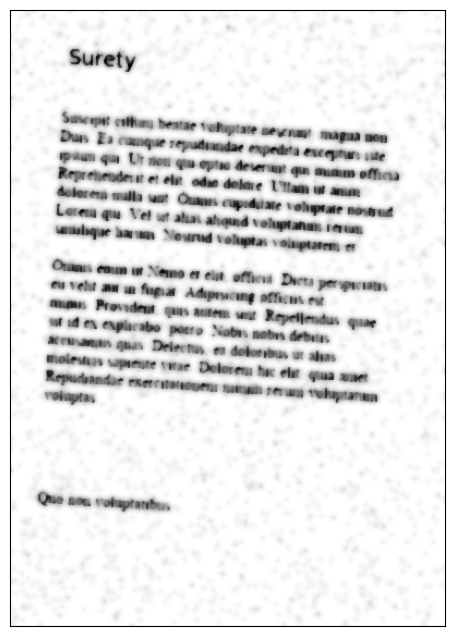

In [11]:
id, sample_image_path, sample_label_path = get_random_img()
img = Image.open(sample_image_path)
img = np.array(img)

img = denoise(img)
display_image(img=img)

In [12]:
def fft(img, to_PIL=True):
    f = cv2.dft(np.float32(img))    # Discrete Fourier transform
    fshift = np.fft.fftshift(f)     # Shift the zero-frequency component to the center of the spectrum
    f_abs = np.abs(fshift) + 1.0    # shift to ensure no zeroes are present in image array
    f_img = 20 * np.log(f_abs)      # final result
    if to_PIL:
        return Image.fromarray(f_img)
    return f_img

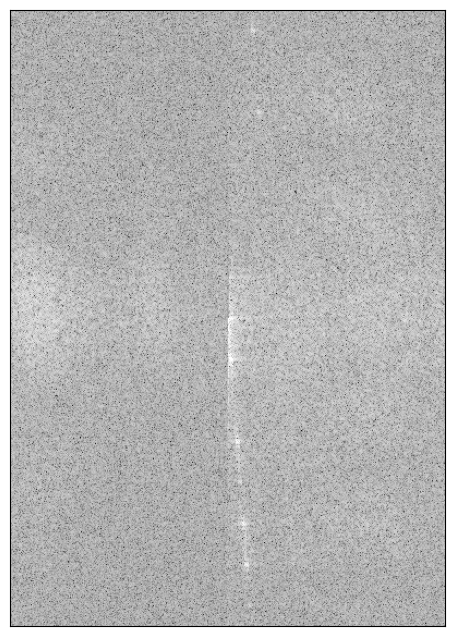

In [13]:
id, sample_image_path, sample_label_path = get_random_img()
img = Image.open(sample_image_path)
img = np.array(img)
# img = cv2.imread(sample_image_path)
# img = img[:,:,0]

f_img = fft(img)
display_image(img=f_img)

In [14]:
def preprocess(img):
    return fft(denoise(img))

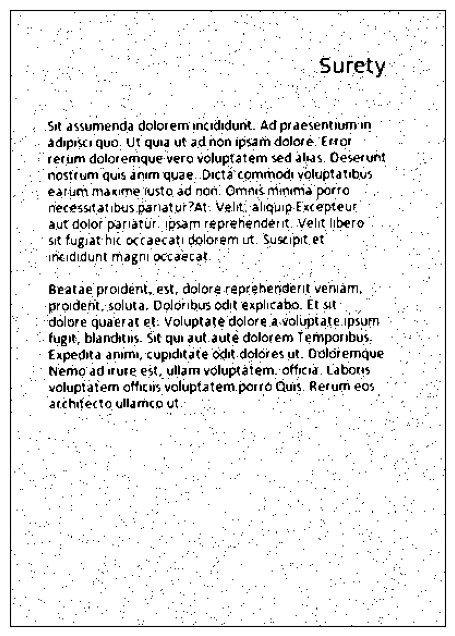

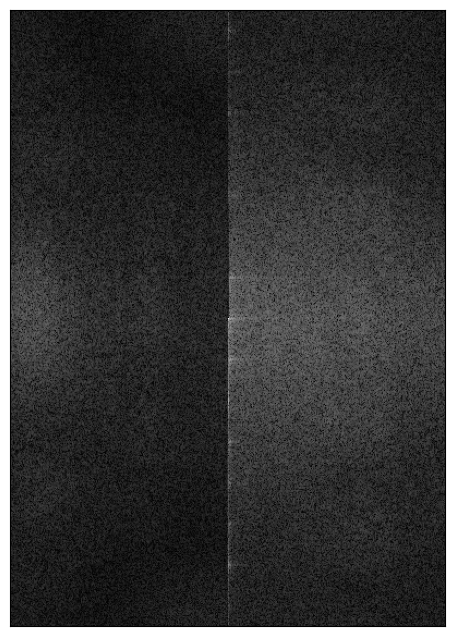

In [15]:
id, sample_image_path, sample_label_path = get_random_img()
img = cv2.imread(sample_image_path)
img = img[:,:,0]

f_img = preprocess(img)
display_image(img=img)
display_image(img=f_img)

После применения шумоподавления и быстрого преобразования Фурье (FFT), можно хорошо увидеть угол отклонения текста, применяем ко всем изображениям

In [16]:
prep_image_paths = os.path.join(root, 'preprocessed images')
os.mkdir(prep_image_paths)

for img_name in os.listdir(image_paths):
    img_src_path = os.path.join(image_paths, img_name)
    img = Image.open(img_src_path)
    img = np.array(img)
    img = preprocess(img)

    img = np.array(img)
    img = Image.fromarray((img).astype(np.uint8))
    img_dst_path = os.path.join(prep_image_paths, img_name)
    img.save(img_dst_path)

In [17]:
labels = {}
for textfile in label_list:
    path = os.path.join(label_paths, textfile)
    with open(path) as f:
        label = float(f.read())
    file_name = textfile.split('.')[0]
    labels[file_name] = round(label)

In [18]:
labels['scan_000'], labels['scan_010'], labels['scan_499']


(0, -3, -1)

In [19]:
def prepare_data(prep_image_paths, train_list, labels):
    X = []
    y = []
    for img_name in train_list:
        img_path = os.path.join(prep_image_paths, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))  # уменьшаем размерность
        X.append(img.flatten())  # преобразуем в 1D массив
        
        file_name = img_name.split('.')[0]
        y.append(labels[file_name])
    
    return np.array(X), np.array(y)

# Подготовка данных
X, y = prepare_data(prep_image_paths, train_list, labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Оценка результатов
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

print("Linear Regression Results:")
print(f"Train MSE: {mean_squared_error(y_train, lr_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, lr_test_pred)}")
print(f"Train R²: {r2_score(y_train, lr_train_pred)}")
print(f"Test R²: {r2_score(y_test, lr_test_pred)}")

Linear Regression Results:
Train MSE: 4.142650658473656e-29
Test MSE: 0.9592701238785467
Train R²: 1.0
Test R²: 0.8956362196050147


In [20]:
from sklearn.neighbors import KNeighborsRegressor

# Обучение модели
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Оценка результатов
knn_train_pred = knn_model.predict(X_train)
knn_test_pred = knn_model.predict(X_test)

print("\nKNN Results:")
print(f"Train MSE: {mean_squared_error(y_train, knn_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, knn_test_pred)}")
print(f"Train R²: {r2_score(y_train, knn_train_pred)}")
print(f"Test R²: {r2_score(y_test, knn_test_pred)}")



KNN Results:
Train MSE: 1.2137
Test MSE: 2.2228
Train R²: 0.8594318118480266
Test R²: 0.7581705035031986


In [21]:
from sklearn.ensemble import RandomForestRegressor

# Обучение модели
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Оценка результатов
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

print("\nRandom Forest Results:")
print(f"Train MSE: {mean_squared_error(y_train, rf_train_pred)}")
print(f"Test MSE: {mean_squared_error(y_test, rf_test_pred)}")
print(f"Train R²: {r2_score(y_train, rf_train_pred)}")
print(f"Test R²: {r2_score(y_test, rf_test_pred)}")


Random Forest Results:
Train MSE: 0.198727
Test MSE: 1.1603219999999999
Train R²: 0.9769838557082663
Test R²: 0.8737627834109405


In [33]:
# Импорт дополнительных библиотек
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A
from sklearn.preprocessing import StandardScaler


/Library/Python/3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
class RotationDataset(Dataset):
    def __init__(self, image_paths, image_list, label_paths, train=True):
        self.image_paths = image_paths
        self.image_list = image_list
        self.label_paths = label_paths
        self.train = train
        
        # Загружаем метки
        self.labels = {}
        for img_name in self.image_list:
            label_file = os.path.join(self.label_paths, img_name.replace('.png', '.txt'))
            with open(label_file, 'r') as f:
                self.labels[img_name] = float(f.read().strip())
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_paths, img_name)
        
        # Загрузка и предобработка изображения
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (64, 64))
        
        # Нормализация изображения
        image = image.astype(np.float32) / 255.0
        image = torch.FloatTensor(image).unsqueeze(0)
        
        # Получаем метку
        label = self.labels[img_name]
        label = torch.FloatTensor([label])
        
        return image, label


In [44]:
class ImprovedRotationCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ImprovedRotationCNN, self).__init__()
        
        # Сверточные блоки
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Полносвязные слои
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.fc(x)
        return x

In [45]:
# Подготовка данных
train_idx, temp_idx = train_test_split(range(len(train_list)), test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_list_split = [train_list[i] for i in train_idx]
val_list_split = [train_list[i] for i in val_idx]
test_list_split = [train_list[i] for i in test_idx]


In [46]:
# Создание датасетов
train_dataset = RotationDataset(image_paths, train_list_split, label_paths, train=True)
val_dataset = RotationDataset(image_paths, val_list_split, label_paths, train=False)
test_dataset = RotationDataset(image_paths, test_list_split, label_paths, train=False)


In [47]:
# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [48]:
# Обучение модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedRotationCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


In [49]:
# Обучение
num_epochs = 50
best_val_loss = float('inf')
patience = 7
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Обучение
    model.train()
    running_train_loss = 0.0
    
    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Валидация
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            outputs = model(batch_images)
            val_loss = criterion(outputs, batch_labels)
            running_val_loss += val_loss.item()
    
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    
    # Early stopping и сохранение лучшей модели
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f'Early stopping на эпохе {epoch+1}')
        break
    
    # Обновление learning rate
    scheduler.step(epoch_val_loss)
    
    print(f'Эпоха {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')


Эпоха 1/50
Train Loss: 13.0357, Val Loss: 7.4892
Эпоха 2/50
Train Loss: 10.5742, Val Loss: 7.5074
Эпоха 3/50
Train Loss: 8.4087, Val Loss: 7.4524
Эпоха 4/50
Train Loss: 8.0852, Val Loss: 7.2002
Эпоха 5/50
Train Loss: 5.3681, Val Loss: 8.1982
Эпоха 6/50
Train Loss: 2.4565, Val Loss: 3.6331
Эпоха 7/50
Train Loss: 1.7093, Val Loss: 5.6269
Эпоха 8/50
Train Loss: 1.4050, Val Loss: 4.2044
Эпоха 9/50
Train Loss: 1.2001, Val Loss: 1.6412
Эпоха 10/50
Train Loss: 1.0936, Val Loss: 0.6721
Эпоха 11/50
Train Loss: 1.1686, Val Loss: 1.0404
Эпоха 12/50
Train Loss: 0.8680, Val Loss: 1.1062
Эпоха 13/50
Train Loss: 0.9357, Val Loss: 1.1742
Эпоха 14/50
Train Loss: 1.0808, Val Loss: 2.9758
Эпоха 15/50
Train Loss: 0.8861, Val Loss: 0.8060
Эпоха 16/50
Train Loss: 0.6325, Val Loss: 0.7987
Early stopping на эпохе 17


In [50]:
# Загрузка лучшей модели и оценка на тестовом наборе
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_predictions = []
test_labels = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(batch_labels.numpy())

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

print("\nИтоговые результаты:")
print(f"Test MSE: {mean_squared_error(test_labels, test_predictions):.4f}")
print(f"Test R²: {r2_score(test_labels, test_predictions):.4f}")
print(f"Test MAE: {mean_absolute_error(test_labels, test_predictions):.4f}")

/var/folders/z2/889mcdgx68s4l2p7x5f310hm0000gn/T/ipykernel_91218/3221623827.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.


Итоговые результаты:
Test MSE: 1.0148
Test R²: 0.9023
Test MAE: 0.8200


In [51]:
# Функция для обучения модели
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, patience=7):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Обучение
        model.train()
        running_loss = 0.0
        for batch_images, batch_labels in train_loader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        # Валидация
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_images, batch_labels in val_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs = model(batch_images)
                val_loss = criterion(outputs, batch_labels)
                running_val_loss += val_loss.item()
        
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        
        # Обновление learning rate
        scheduler.step(epoch_val_loss)
        
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            # Сохранение лучшей модели
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
            
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    
    return train_losses, val_losses


In [37]:
# Подготовка данных
# Разделение на train/val/test
train_idx, temp_idx = train_test_split(range(len(train_list)), test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)


In [38]:
train_list_split = [train_list[i] for i in train_idx]
val_list_split = [train_list[i] for i in val_idx]
test_list_split = [train_list[i] for i in test_idx]

In [39]:
# Создание датасетов
train_dataset = RotationDataset(prep_image_paths, train_list_split, labels, train=True)
val_dataset = RotationDataset(prep_image_paths, val_list_split, labels, train=False)
test_dataset = RotationDataset(prep_image_paths, test_list_split, labels, train=False)


/Library/Python/3.9/site-packages/albumentations/core/validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [40]:
# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [41]:
# Инициализация модели и обучение
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedRotationCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


/Library/Python/3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [52]:
# Обучение модели
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device
)

Epoch 1/50
Train Loss: 0.8201, Val Loss: 0.9617
Epoch 2/50
Train Loss: 0.7416, Val Loss: 0.6390
Epoch 3/50
Train Loss: 0.8038, Val Loss: 0.6524
Epoch 4/50
Train Loss: 0.8316, Val Loss: 0.5865
Epoch 5/50
Train Loss: 0.7194, Val Loss: 0.7185
Epoch 6/50
Train Loss: 0.8917, Val Loss: 0.6735
Epoch 7/50
Train Loss: 0.7437, Val Loss: 0.6803
Epoch 8/50
Train Loss: 0.7280, Val Loss: 0.6644
Epoch 9/50
Train Loss: 0.7599, Val Loss: 0.6618
Epoch 10/50
Train Loss: 0.7033, Val Loss: 0.6479
Early stopping at epoch 11


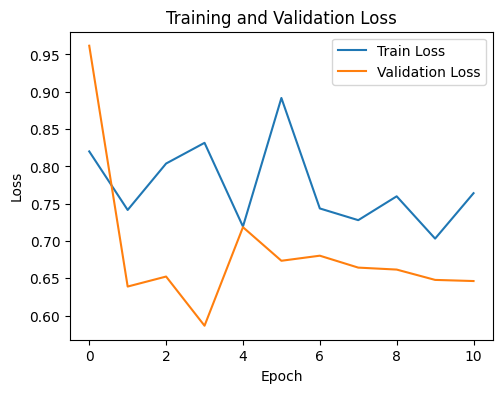

In [53]:
# Визуализация результатов
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [54]:
# Загрузка лучшей модели и оценка на тестовом наборе
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_predictions = []
test_labels = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(batch_labels.numpy())

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

print("\nFinal Test Results:")
print(f"Test MSE: {mean_squared_error(test_labels, test_predictions):.4f}")
print(f"Test R²: {r2_score(test_labels, test_predictions):.4f}")
print(f"Test MAE: {mean_absolute_error(test_labels, test_predictions):.4f}")

/var/folders/z2/889mcdgx68s4l2p7x5f310hm0000gn/T/ipykernel_91218/68566264.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt


Final Test Results:
Test MSE: 0.8552
Test R²: 0.9176
Test MAE: 0.7504


Проанализируем результаты каждой модели:
1. Линейная регрессия:
Train MSE: 4.14e-29 (практически 0)
Test MSE: 0.959
Train R²: 1.0
Test R²: 0.896
Вывод: Явное переобучение модели. Идеальные результаты на тренировочном наборе (R² = 1.0) и значительно хуже на тестовом говорят о том, что модель "запомнила" тренировочные данные, но плохо обобщает новые.
2. KNN:
Train MSE: 1.214
Test MSE: 2.223
Train R²: 0.859
Test R²: 0.758
Вывод: Наихудшие результаты среди всех моделей. Большая разница между тренировочными и тестовыми метриками также указывает на переобучение, хотя и не такое сильное как у линейной регрессии.
3. Random Forest:
Train MSE: 0.199
Test MSE: 1.160
Train R²: 0.977
Test R²: 0.874
Вывод: Хорошие результаты, но также присутствует переобучение (разница между train и test метриками значительная).
4. Нейронная сеть:
Первый метод:
Test MSE: 1.015
Test R²: 0.902
Test MAE: 0.820
Второй метод (улучшенный):
Test MSE: 0.855
Test R²: 0.918
Test MAE: 0.750
Общие выводы:
Лучшая модель - улучшенная нейронная сеть (второй метод):
Наилучший R² (0.918)
Наименьший MSE (0.855)
Наименьший MAE (0.750)
Проблемы переобучения:
Линейная регрессия показывает признаки сильного переобучения.
Random Forest и KNN также страдают от переобучения, но в меньшей степени.
Улучшение архитектуры CNN (от первого ко второму методу) дало значительный прирост в качестве:
MSE улучшился с 1.015 до 0.855
R² вырос с 0.902 до 0.918
MAE уменьшился с 0.820 до 0.750